### Dropping Cols that only appear once and binning WRBTR by zero and then by quantile

In [140]:
import numpy as np
import pandas as pd

from get_ids import get_ids_of_easy_outliers
#load data
df = pd.read_csv("data/datathon_data.csv")

for col in categorical_columns:
    # Get the value counts of each category in the column
    value_counts = df[col].value_counts()
    
    # Find categories that appear only once
    categories_to_drop = value_counts[value_counts == 1].index
    
    # Drop these categories from the column
    df = df[~df[col].isin(categories_to_drop)]

df = df.drop(columns=["BELNR"])

#df["WRBTR"] = df['WRBTR'].apply(lambda x: np.log(x) if x > 0 else x)
#df["DMBTR"]= np.log(df["DMBTR"])



In [53]:
df.head()


,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,0,C3,C31,C9,C92,A3,B1,12.546037,0.000000,regular
1,1,C1,C18,C7,C76,A1,B2,11.774186,12.402227,regular
2,2,C1,C19,C2,C20,A1,B3,13.772043,14.973598,regular
3,3,C4,C48,C9,C95,A2,B1,14.801965,10.267366,regular
4,4,C5,C58,C1,C19,A3,B1,13.721765,5.846439,regular


### Apply SMOTE to get Equal Anom to Regular based on the "hardest 30"

In [141]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
# Drop BELNR (Account Document Number) since it's just an identifier

df = pd.get_dummies(df, columns=['BUKRS', 'WAERS', 'KTOSL', 'PRCTR', 'BSCHL', 'HKONT'], drop_first=True)

# Convert target variable to binary (if it's not already)
df[target_col] = df[target_col].map({'regular': 0, 'anomal': 1})

# drop rare values

# Split your dataset into features and target variable
X = df.drop(columns=['label'])
y = df['label']

# Split data into training and testing sets (you can also split the data first)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes in the training data
smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Original training set: {X_train.shape}, {y_train.value_counts()}")
print(f"Resampled training set: {X_train_resampled.shape}, {y_train_resampled.value_counts()}")


Original training set: (426351, 200), label
0    426325
1        26
Name: count, dtype: int64
Resampled training set: (468957, 200), label
0    426325
1     42632
Name: count, dtype: int64


### Train Decision tree on SMOTE Dataset and then test on regular

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    106584
           1       0.75      0.75      0.75         4

    accuracy                           1.00    106588
   macro avg       0.87      0.87      0.87    106588
weighted avg       1.00      1.00      1.00    106588


Decision Tree Rules:
|--- BUKRS_C11 <= 0.50
|   |--- PRCTR_C18 <= 0.50
|   |   |--- class: 0
|   |--- PRCTR_C18 >  0.50
|   |   |--- BUKRS_C20 <= 0.50
|   |   |   |--- class: 0
|   |   |--- BUKRS_C20 >  0.50
|   |   |   |--- WRBTR <= 53852.42
|   |   |   |   |--- class: 0
|   |   |   |--- WRBTR >  53852.42
|   |   |   |   |--- class: 0
|--- BUKRS_C11 >  0.50
|   |--- WRBTR <= 54423.25
|   |   |--- class: 0
|   |--- WRBTR >  54423.25
|   |   |--- WRBTR <= 54517.63
|   |   |   |--- DMBTR <= 910668.84
|   |   |   |   |--- class: 1
|   |   |   |--- DMBTR >  910668.84
|   |   |   |   |--- class: 1
|   |   |--- WRBTR >  54517.63
|   |   |   |--- c

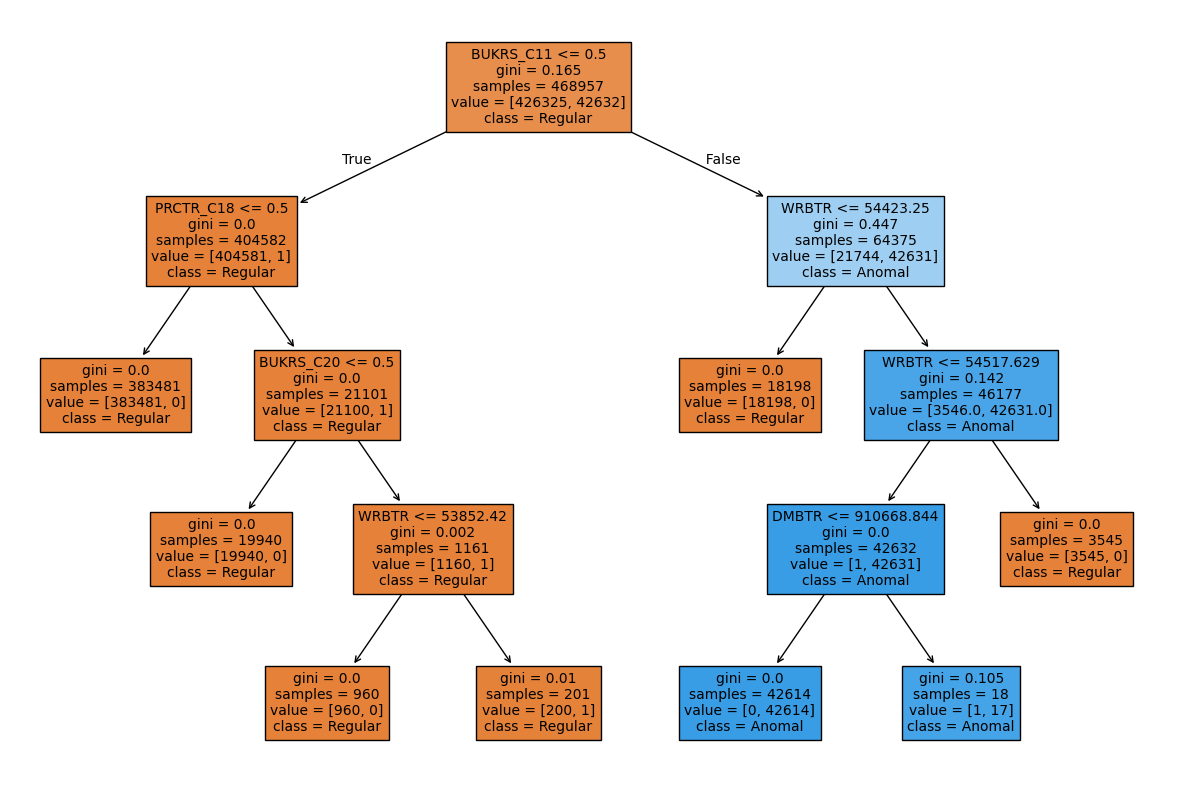

In [142]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree



# Define features and target
X = df.drop(columns=[target_col])  # Features (all columns except target)
y = df[target_col]  # Target variable (0 = regular, 1 = anomal)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree model on the resampled data
tree_clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, random_state=42)
tree_clf.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred = tree_clf.predict(X_test)  # Use the original test set (no resampling)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Extract decision rules
print("\nDecision Tree Rules:")
tree_rules = export_text(tree_clf, feature_names=X.columns.tolist())
print(tree_rules)

# Visualize the tree
plt.figure(figsize=(15, 10))
plot_tree(tree_clf, feature_names=X.columns.tolist(), class_names=['Regular', 'Anomal'], filled=True, fontsize=10)
plt.show()


## Random Tessts


In [10]:
print(df.groupby('label')[['DMBTR', 'WRBTR']].describe())


          DMBTR                                                             \
          count           mean           std            min            25%   
label                                                                        
0      532909.0  910647.009645  1.879574e+06       2.600000  215905.350000   
1          30.0  910650.663315  1.061637e+01  910631.632279  910646.373036   

                                                      WRBTR                \
                 50%            75%           max     count          mean   
label                                                                       
0      486308.390000  974958.000000  9.244552e+07  532909.0  54441.851725   
1      910649.530343  910656.796503  9.106766e+05      30.0  54443.656397   

                                                                              \
                 std           min           25%           50%           75%   
label                                                          

In [9]:
df['DMBTR_bin'] = pd.qcut(df['DMBTR'], q=10, labels=False, duplicates='drop')
df['WRBTR_bin'] = pd.qcut(df['WRBTR'], q=10, labels=False, duplicates='drop')


In [11]:
df["WRBTR_bin"].value_counts()

WRBTR_bin
1    282783
0    250156
Name: count, dtype: int64

In [12]:
duplicates = df[df.duplicated(subset='WRBTR')]
print(len(duplicates))
df['WRBTR'].describe()

395434


count    5.329390e+05
mean     5.444185e+04
std      4.399694e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.627912e+04
max      5.958504e+07
Name: WRBTR, dtype: float64

In [105]:
df = pd.read_csv("data/datathon_data.csv")

for col in categorical_columns:
    # Get the value counts of each category in the column
    value_counts = df[col].value_counts()
    
    # Find categories that appear only once
    categories_to_drop = value_counts[value_counts == 1].index
    
    # Drop these categories from the column
    df = df[~df[col].isin(categories_to_drop)]
a=df[df["label"]!="regular"]
len(a["PRCTR"].unique())
b=df[df["label"]=="regular"]
a.head(30)


,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
12939,12939,C1,C20,C1,C18,A1,B1,910658.284578,54449.838820,anomal
32317,32317,C1,C11,C1,C53,A1,B1,910653.005238,54439.211421,anomal
34058,34058,C1,C11,C1,C91,A1,B1,910668.887465,54440.856583,anomal
34059,34059,C1,C11,C1,C64,A1,B1,910631.632279,54443.283794,anomal
43399,43399,C1,C11,C1,C79,A1,B1,910650.440131,54435.055247,anomal
97954,97954,C1,C11,C1,C68,A1,B1,910648.636111,54442.618111,anomal
144286,144286,C1,C11,C1,C76,A1,B1,910645.076191,54448.440199,anomal
170320,170320,C1,C11,C1,C30,A1,B1,910645.965114,54452.809780,anomal
183064,183064,C1,C11,C1,C82,A1,B1,910648.873494,54436.705575,anomal
213105,213105,C1,C17,C1,C20,A1,B1,910664.385738,54436.897572,anomal


In [108]:
unique_prctr_counts = df.groupby('BUKRS')['PRCTR'].nunique()
print(unique_prctr_counts)
a["exchange"]=a["WRBTR"]/a["DMBTR"]
a.head(30)


BUKRS
C10    90
C11    90
C12    90
C13    90
C14    90
       ..
C95    90
C96    90
C97    90
C98    90
C99    90
Name: PRCTR, Length: 90, dtype: int64


C:\Users\Theo\AppData\Local\Temp\ipykernel_21748\825998273.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["exchange"]=a["WRBTR"]/a["DMBTR"]


,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label,exchange
12939,12939,C1,C20,C1,C18,A1,B1,910658.284578,54449.838820,anomal,0.059792
32317,32317,C1,C11,C1,C53,A1,B1,910653.005238,54439.211421,anomal,0.059780
34058,34058,C1,C11,C1,C91,A1,B1,910668.887465,54440.856583,anomal,0.059781
34059,34059,C1,C11,C1,C64,A1,B1,910631.632279,54443.283794,anomal,0.059786
43399,43399,C1,C11,C1,C79,A1,B1,910650.440131,54435.055247,anomal,0.059776
97954,97954,C1,C11,C1,C68,A1,B1,910648.636111,54442.618111,anomal,0.059784
144286,144286,C1,C11,C1,C76,A1,B1,910645.076191,54448.440199,anomal,0.059791
170320,170320,C1,C11,C1,C30,A1,B1,910645.965114,54452.809780,anomal,0.059796
183064,183064,C1,C11,C1,C82,A1,B1,910648.873494,54436.705575,anomal,0.059778
213105,213105,C1,C17,C1,C20,A1,B1,910664.385738,54436.897572,anomal,0.059777


In [103]:
len(a[(a["BUKRS"] == "C11") & (a["PRCTR"].isin(df["PRCTR"]))])


28

In [113]:
df["exchange"]=df["WRBTR"]/df["DMBTR"]
df[(df["exchange"]<0.06)&(df["exchange"]>0)]

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label,exchange
3,3,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular,0.010731
4,4,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular,0.000380
10,10,C1,C16,C9,C99,A1,B1,1036068.80,198.00,regular,0.000191
15,15,C8,C80,C7,C75,A1,B2,2065589.12,2692.00,regular,0.001303
17,17,C2,C21,C8,C82,A1,B3,330161.24,19082.00,regular,0.057796
...,...,...,...,...,...,...,...,...,...,...,...
532983,532983,C5,C59,C1,C10,A3,B1,1541218.76,18510.00,regular,0.012010
532992,532992,C1,C19,C1,C14,A1,B1,1421502.74,11178.00,regular,0.007864
532993,532993,C2,C20,C6,C65,A1,B2,188740.09,122.00,regular,0.000646
532996,532996,C1,C12,C1,C18,A1,B1,1521388.31,172.00,regular,0.000113


In [117]:
import pandas as pd

# Assuming your dataframe is called df
df['DMBTR_diff'] = df['DMBTR'].diff()  # Calculate difference in DMBTR between consecutive rows
df['WRBTR_diff'] = df['WRBTR'].diff()  # Calculate difference in WRBTR between consecutive rows

# Calculate the mean of the squared differences
dmbtr_variance_avg = (df['DMBTR_diff']**2).mean()  # Mean of squared differences for DMBTR
wrbtr_variance_avg = (df['WRBTR_diff']**2).mean()  # Mean of squared differences for WRBTR

print(f"Average variance in DMBTR differences: {dmbtr_variance_avg}")
print(f"Average variance in WRBTR differences: {wrbtr_variance_avg}")


Average variance in DMBTR differences: 7063950977031.813
Average variance in WRBTR differences: 387331384807.86505


In [116]:
import pandas as pd

# Assuming your dataframe is called df
a['DMBTR_diff'] = a['DMBTR'].diff()  # Calculate difference in DMBTR between consecutive rows
a['WRBTR_diff'] = a['WRBTR'].diff()  # Calculate difference in WRBTR between consecutive rows

# Calculate the mean of the squared differences
dmbtr_variance_avg = (a['DMBTR_diff']**2).mean()  # Mean of squared differences for DMBTR
wrbtr_variance_avg = (a['WRBTR_diff']**2).mean()  # Mean of squared differences for WRBTR

print(f"Average variance in DMBTR differences: {dmbtr_variance_avg}")
print(f"Average variance in WRBTR differences: {wrbtr_variance_avg}")


Average variance in DMBTR differences: 248.3308162294835
Average variance in WRBTR differences: 142.57362620759238


C:\Users\Theo\AppData\Local\Temp\ipykernel_21748\1431932503.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['DMBTR_diff'] = a['DMBTR'].diff()  # Calculate difference in DMBTR between consecutive rows
C:\Users\Theo\AppData\Local\Temp\ipykernel_21748\1431932503.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['WRBTR_diff'] = a['WRBTR'].diff()  # Calculate difference in WRBTR between consecutive rows


In [122]:
len(c)

100

In [ ]:
df = pd.read_csv("data/datathon_data.csv")
c=df[df["label"]!="regular"]

# Assuming your dataframe is called df
c['DMBTR_diff'] = c['DMBTR'].diff()  # Calculate difference in DMBTR between consecutive rows
c['WRBTR_diff'] = c['WRBTR'].diff()  # Calculate difference in WRBTR between consecutive rows

# Calculate the mean of the squared differences
dmbtr_variance_avg = (c['DMBTR_diff']**2).mean()  # Mean of squared differences for DMBTR
wrbtr_variance_avg = (c['WRBTR_diff']**2).mean()  # Mean of squared differences for WRBTR

print(f"Average variance in DMBTR differences: {dmbtr_variance_avg}")
print(f"Average variance in WRBTR differences: {wrbtr_variance_avg}")

Average variance in DMBTR differences: 3554571213521916.0
Average variance in WRBTR differences: 1503469491110897.5


C:\Users\Theo\AppData\Local\Temp\ipykernel_21748\451828933.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['DMBTR_diff'] = c['DMBTR'].diff()  # Calculate difference in DMBTR between consecutive rows
C:\Users\Theo\AppData\Local\Temp\ipykernel_21748\451828933.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['WRBTR_diff'] = c['WRBTR'].diff()  # Calculate difference in WRBTR between consecutive rows
